In [36]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_log_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Input
from darts.models import FFT
from darts import TimeSeries

# Gasoline RBOB

## 7:3

In [37]:
# Đọc dữ liệu
df = pd.read_csv('../dataset/Gasoline RBOB.csv')

In [38]:
# Tiền xử lý dữ liệu
# Chuyển đổi cột 'Date' thành kiểu dữ liệu datetime
df['Date'] = pd.to_datetime(df['Date'])

In [39]:
df

,Date,Price,Open,High,Low,Vol.,Change %
0,2024-05-31,2.4174,2.3914,2.4331,2.3914,16.83K,0.53%
1,2024-05-30,2.4046,2.4560,2.4613,2.4295,0.44K,-2.43%
2,2024-05-29,2.4644,2.5208,2.5304,2.4579,1.28K,-1.78%
3,2024-05-28,2.5090,2.5151,2.5244,2.5022,0.33K,-0.20%
4,2024-05-27,2.5140,2.5020,2.5154,2.5020,0.02K,1.53%
...,...,...,...,...,...,...,...
1622,2019-03-06,1.5674,1.7604,1.7919,1.7524,91.54K,0.47%
1623,2019-03-05,1.5601,1.7474,1.7735,1.7387,61.43K,0.46%
1624,2019-03-04,1.5530,1.7285,1.7660,1.7285,62.55K,-10.41%
1625,2019-03-03,1.7335,1.7310,1.7420,1.7298,NaN,12.89%


In [40]:

# Chuyển đổi cột 'Vol.' thành số
# Chuyển đổi cột 'Change %' thành số
def convert_volume_to_number(volume_str):
    if isinstance(volume_str, float):
        return volume_str
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    else:
        return volume_str


def convert_change_to_number(change_str):
    new_change = float(change_str.strip('%'))
    return new_change

def convert_str_to_number(str):
    return float(str.replace(',', ''))

df['Vol.'] = df['Vol.'] .apply(convert_volume_to_number)
df['Change %'] = df['Change %'].apply(convert_change_to_number)

# Đảo ngược dữ liệu để dự đoán giá trị trong tương lai
df = df.iloc[::-1].reset_index(drop=True)

In [41]:
# Chuyển đổi cột 'Price' thành mảng NumPy
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index
df

,Date,Price,Open,High,Low,Vol.,Change %
0,2019-03-01,1.5356,1.7521,1.7720,1.7124,69010.0,-1.37
1,2019-03-04,1.5530,1.7285,1.7660,1.7285,62550.0,-10.41
2,2019-03-05,1.5601,1.7474,1.7735,1.7387,61430.0,0.46
3,2019-03-06,1.5674,1.7604,1.7919,1.7524,91540.0,0.47
4,2019-03-07,1.5743,1.7845,1.8160,1.7845,78590.0,0.44
...,...,...,...,...,...,...,...
1330,2024-05-27,2.5140,2.5020,2.5154,2.5020,20.0,1.53
1331,2024-05-28,2.5090,2.5151,2.5244,2.5022,330.0,-0.20
1332,2024-05-29,2.4644,2.5208,2.5304,2.4579,1280.0,-1.78
1333,2024-05-30,2.4046,2.4560,2.4613,2.4295,440.0,-2.43


In [42]:
# Tạo dữ liệu giả cho các ngày cuối tuần thiếu
def fill_missing_weekends(df):
    weekend_data = pd.DataFrame(columns=df.columns)
    all_dates = pd.date_range(start=df['Date'].min(), end=df['Date'].max(), freq='D')
    for date in all_dates:
        # Kiểm tra xem ngày đó có trong dữ liệu không
        if date not in df['Date'].values:
            # Nếu không có, tìm ngày trước và sau đó trong dữ liệu
            previous_day = df[df['Date'] < date]
            next_day = df[df['Date'] > date]
            # Kiểm tra DataFrame có dữ liệu không
            if not previous_day.empty and not next_day.empty:
                previous_day = previous_day.iloc[-1]
                next_day = next_day.iloc[0]
                # Tính toán giá trị trung bình của các cột (trừ cột 'Date')
                new_row_values = (previous_day.drop('Date') + next_day.drop('Date')) / 2
                # Tạo một Series mới với ngày và giá trị mới
                new_row = pd.Series([date] + new_row_values.tolist(), index=df.columns)
                # Thêm dòng dữ liệu vào DataFrame mới
                weekend_data.loc[len(weekend_data)] = new_row

    # Kết hợp dữ liệu gốc và dữ liệu cuối tuần giả mạo
    df = pd.concat([df, weekend_data], ignore_index=True)
    df.sort_values(by='Date', inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

# Áp dụng hàm để điền giá trị cho các ngày cuối tuần
df = fill_missing_weekends(df)

In [43]:
price = df['Price'].values
price = price.reshape(-1, 1)

In [44]:
scaler = MinMaxScaler(feature_range=(0, 1))
price_scaled = scaler.fit_transform(price)

In [45]:
train_size = int(len(price_scaled) * 0.7)
train_data = price_scaled[:train_size]
test_data = price_scaled[train_size:]
series_train = TimeSeries.from_dataframe(pd.DataFrame(train_data, columns=['Price']))
series_test = TimeSeries.from_dataframe(pd.DataFrame(test_data, columns=['Price']))

In [46]:
model = FFT()
model.fit(series_train)

FFT(nr_freqs_to_keep=10, required_matches=None, trend=None, trend_poly_degree=3)

In [47]:
forecast = model.predict(len(series_test))

In [48]:
rmse = np.sqrt(np.mean((series_test.values() - forecast.values()) ** 2))
mae = np.mean(np.abs(series_test.values() - forecast.values()))
mape = np.mean(np.abs((series_test.values() - forecast.values()) / series_test.values())) * 100

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'MAPE: {mape}%')

RMSE: 0.40767674835868395
MAE: 0.3965941362513087
MAPE: 69.43128163572797%


In [49]:
forecast_90 = model.predict(len(series_test) + 90)
print(forecast_90)

<TimeSeries (DataArray) (time: 666, component: 1, sample: 1)> Size: 5kB
array([[[0.38987535]],

       [[0.38662935]],

       [[0.38338487]],

       [[0.38014358]],

       [[0.37690719]],

       [[0.37367741]],

       [[0.37045597]],

       [[0.36724459]],

       [[0.36404501]],

       [[0.36085896]],

...

       [[0.16298649]],

       [[0.16379658]],

       [[0.16463603]],

       [[0.16550434]],

       [[0.16640092]],

       [[0.16732515]],

       [[0.16827633]],

       [[0.16925371]],

       [[0.1702565 ]],

       [[0.17128381]]])
Coordinates:
  * time       (time) int64 5kB 1343 1344 1345 1346 1347 ... 2005 2006 2007 2008
  * component  (component) object 8B 'Price'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None


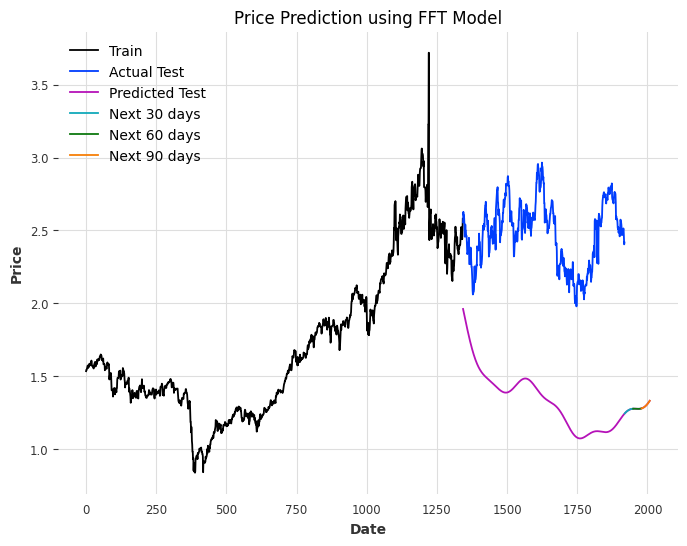

In [50]:
train_data_df = pd.DataFrame(scaler.inverse_transform(train_data), columns=['Price'])
test_data_df = pd.DataFrame(scaler.inverse_transform(test_data), columns=['Price'])
test_predict_df = pd.DataFrame(scaler.inverse_transform(forecast_90.values()), columns=['Price'])

train_length = len(train_data_df)
test_length = len(test_data_df)
test_predict_length = len(test_predict_df)

test_data_df.index = range(train_length, train_length + test_length)
test_predict_df.index = range(train_length, train_length + test_predict_length)

# Plot the data
plt.figure(figsize=(8, 6))
plt.plot(train_data_df, label='Train')
plt.plot(test_data_df, label='Actual Test')
plt.plot(test_predict_df, label='Predicted Test')
plt.plot(test_predict_df[len(series_test):len(series_test)+30], label='Next 30 days')
plt.plot(test_predict_df[len(series_test)+30:len(series_test)+60], label='Next 60 days')
plt.plot(test_predict_df[len(series_test)+60:len(series_test)+90], label='Next 90 days')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Price Prediction using FFT Model')
plt.show()

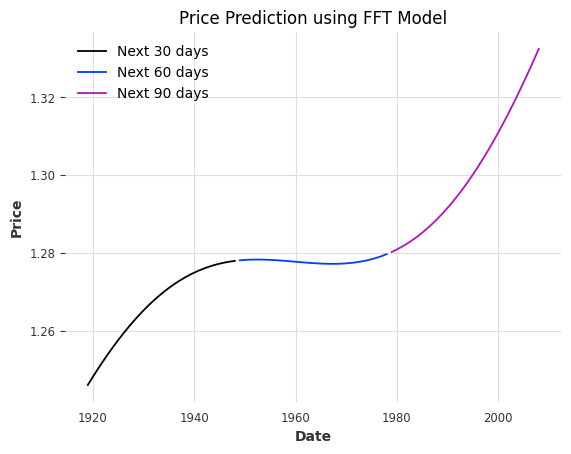

In [51]:
plt.plot(test_predict_df[len(series_test):len(series_test)+30], label='Next 30 days')
plt.plot(test_predict_df[len(series_test)+30:len(series_test)+60], label='Next 60 days')
plt.plot(test_predict_df[len(series_test)+60:len(series_test)+90], label='Next 90 days')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Price Prediction using FFT Model')
plt.show()

## 8:2

In [52]:
train_size = int(len(price_scaled) * 0.8)
train_data = price_scaled[:train_size]
test_data = price_scaled[train_size:]
series_train = TimeSeries.from_dataframe(pd.DataFrame(train_data, columns=['Price']))
series_test = TimeSeries.from_dataframe(pd.DataFrame(test_data, columns=['Price']))

In [53]:
model = FFT()
model.fit(series_train)

FFT(nr_freqs_to_keep=10, required_matches=None, trend=None, trend_poly_degree=3)

In [54]:
forecast = model.predict(len(series_test))

In [55]:
rmse = np.sqrt(np.mean((series_test.values() - forecast.values()) ** 2))
mae = np.mean(np.abs(series_test.values() - forecast.values()))
mape = np.mean(np.abs((series_test.values() - forecast.values()) / series_test.values())) * 100

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'MAPE: {mape}%')

RMSE: 0.3683981795670775
MAE: 0.3526492130986482
MAPE: 61.617558356731195%


In [56]:
forecast_90 = model.predict(len(series_test) + 90)
print(forecast_90)

<TimeSeries (DataArray) (time: 474, component: 1, sample: 1)> Size: 4kB
array([[[0.46835333]],

       [[0.46528685]],

       [[0.4621994 ]],

       [[0.4590921 ]],

       [[0.4559661 ]],

       [[0.45282255]],

       [[0.4496626 ]],

       [[0.44648741]],

       [[0.44329815]],

       [[0.44009601]],

...

       [[0.09256   ]],

       [[0.09342153]],

       [[0.09428216]],

       [[0.09514135]],

       [[0.09599858]],

       [[0.09685334]],

       [[0.09770515]],

       [[0.09855352]],

       [[0.09939801]],

       [[0.10023818]]])
Coordinates:
  * time       (time) int64 4kB 1535 1536 1537 1538 1539 ... 2005 2006 2007 2008
  * component  (component) object 8B 'Price'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None


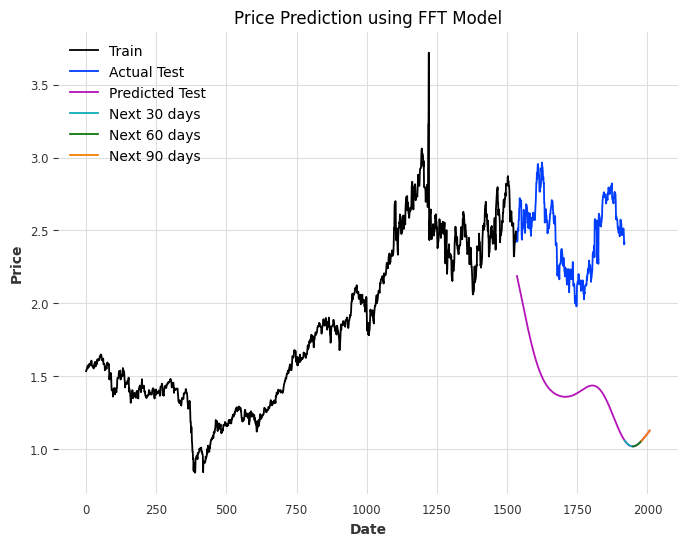

In [57]:
train_data_df = pd.DataFrame(scaler.inverse_transform(train_data), columns=['Price'])
test_data_df = pd.DataFrame(scaler.inverse_transform(test_data), columns=['Price'])
test_predict_df = pd.DataFrame(scaler.inverse_transform(forecast_90.values()), columns=['Price'])

train_length = len(train_data_df)
test_length = len(test_data_df)
test_predict_length = len(test_predict_df)

test_data_df.index = range(train_length, train_length + test_length)
test_predict_df.index = range(train_length, train_length + test_predict_length)

# Plot the data
plt.figure(figsize=(8, 6))
plt.plot(train_data_df, label='Train')
plt.plot(test_data_df, label='Actual Test')
plt.plot(test_predict_df, label='Predicted Test')
plt.plot(test_predict_df[len(series_test):len(series_test)+30], label='Next 30 days')
plt.plot(test_predict_df[len(series_test)+30:len(series_test)+60], label='Next 60 days')
plt.plot(test_predict_df[len(series_test)+60:len(series_test)+90], label='Next 90 days')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Price Prediction using FFT Model')
plt.show()

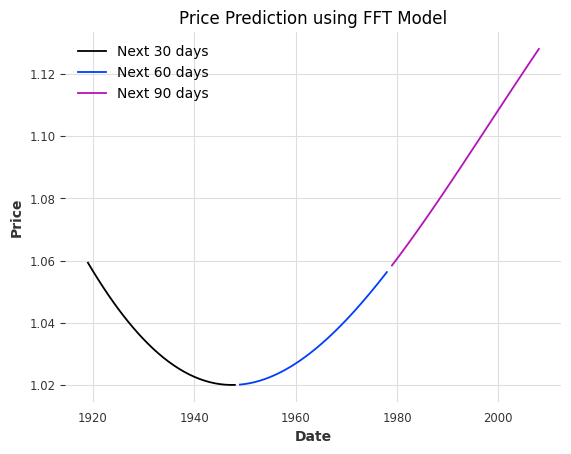

In [58]:
plt.plot(test_predict_df[len(series_test):len(series_test)+30], label='Next 30 days')
plt.plot(test_predict_df[len(series_test)+30:len(series_test)+60], label='Next 60 days')
plt.plot(test_predict_df[len(series_test)+60:len(series_test)+90], label='Next 90 days')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Price Prediction using FFT Model')
plt.show()

### 9:1

In [59]:
train_size = int(len(price_scaled) * 0.9)
train_data = price_scaled[:train_size]
test_data = price_scaled[train_size:]
series_train = TimeSeries.from_dataframe(pd.DataFrame(train_data, columns=['Price']))
series_test = TimeSeries.from_dataframe(pd.DataFrame(test_data, columns=['Price']))

In [60]:
model = FFT()
model.fit(series_train)

FFT(nr_freqs_to_keep=10, required_matches=None, trend=None, trend_poly_degree=3)

In [61]:
forecast = model.predict(len(series_test))

In [62]:
rmse = np.sqrt(np.mean((series_test.values() - forecast.values()) ** 2))
mae = np.mean(np.abs(series_test.values() - forecast.values()))
mape = np.mean(np.abs((series_test.values() - forecast.values()) / series_test.values())) * 100

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'MAPE: {mape}%')

RMSE: 0.327288431689172
MAE: 0.3008062997359718
MAPE: 52.51370729225705%


In [63]:
forecast_90 = model.predict(len(series_test) + 90)
print(forecast_90)

<TimeSeries (DataArray) (time: 282, component: 1, sample: 1)> Size: 2kB
array([[[0.37243662]],

       [[0.37004365]],

       [[0.36766176]],

       [[0.36529125]],

       [[0.36293242]],

       [[0.36058556]],

       [[0.35825097]],

       [[0.35592891]],

       [[0.35361969]],

       [[0.35132357]],

...

       [[0.20295293]],

       [[0.20248163]],

       [[0.20200216]],

       [[0.20151459]],

       [[0.201019  ]],

       [[0.20051544]],

       [[0.200004  ]],

       [[0.19948475]],

       [[0.19895777]],

       [[0.19842315]]])
Coordinates:
  * time       (time) int64 2kB 1727 1728 1729 1730 1731 ... 2005 2006 2007 2008
  * component  (component) object 8B 'Price'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None


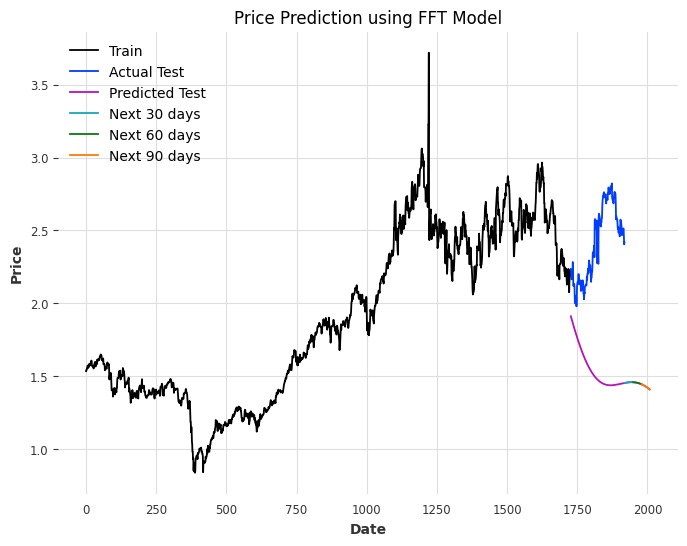

In [64]:
train_data_df = pd.DataFrame(scaler.inverse_transform(train_data), columns=['Price'])
test_data_df = pd.DataFrame(scaler.inverse_transform(test_data), columns=['Price'])
test_predict_df = pd.DataFrame(scaler.inverse_transform(forecast_90.values()), columns=['Price'])

train_length = len(train_data_df)
test_length = len(test_data_df)
test_predict_length = len(test_predict_df)

test_data_df.index = range(train_length, train_length + test_length)
test_predict_df.index = range(train_length, train_length + test_predict_length)

# Plot the data
plt.figure(figsize=(8, 6))
plt.plot(train_data_df, label='Train')
plt.plot(test_data_df, label='Actual Test')
plt.plot(test_predict_df, label='Predicted Test')
plt.plot(test_predict_df[len(series_test):len(series_test)+30], label='Next 30 days')
plt.plot(test_predict_df[len(series_test)+30:len(series_test)+60], label='Next 60 days')
plt.plot(test_predict_df[len(series_test)+60:len(series_test)+90], label='Next 90 days')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Price Prediction using FFT Model')
plt.show()

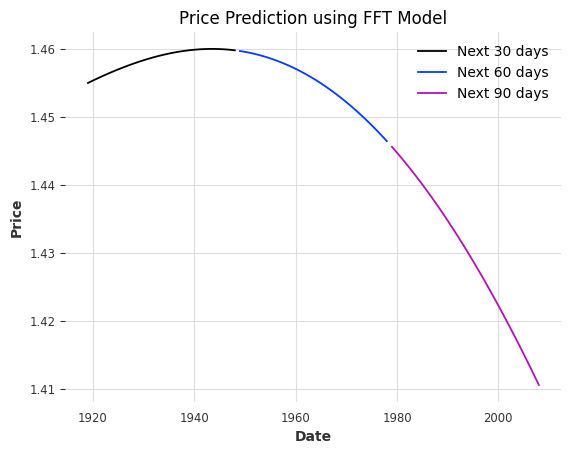

In [65]:
plt.plot(test_predict_df[len(series_test):len(series_test)+30], label='Next 30 days')
plt.plot(test_predict_df[len(series_test)+30:len(series_test)+60], label='Next 60 days')
plt.plot(test_predict_df[len(series_test)+60:len(series_test)+90], label='Next 90 days')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Price Prediction using FFT Model')
plt.show()